In [1]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import r2_score, rmse
from darts.datasets import EnergyDataset
from darts.utils.statistics import plot_acf, check_seasonality


/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


# Loading Data

In [2]:
df = pd.read_csv('df_clean.csv', index_col=0)

In [3]:
df.head()

,date,Price
0,01.01.2020 00:00,33.42
1,01.01.2020 01:00,31.77
2,01.01.2020 02:00,31.57
3,01.01.2020 03:00,31.28
4,01.01.2020 04:00,30.85


Train size :  17545
Test size  :  8759



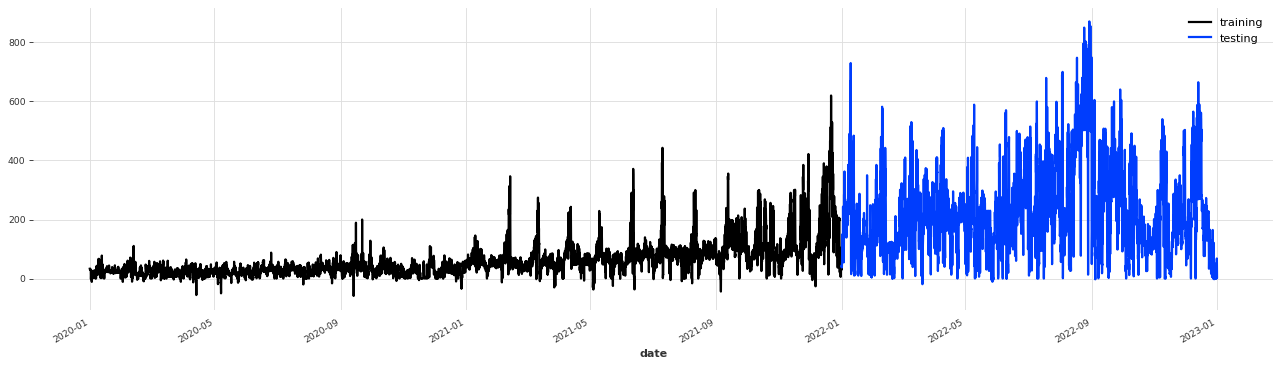

In [4]:
series = TimeSeries.from_dataframe(df, time_col='date', value_cols = 'Price', fill_missing_dates=True, freq=None)

# dart recommendation, splitting dataset into train ad test
# 2 yrs train and 1 year test
# no random split as the data is timeseries data
train, test = series.split_before(pd.Timestamp("01.01.2022 01:00"))
print("Train size : ", len(train))
print("Test size  : ", len(test))
print()

plt.figure(figsize=(20, 5), dpi=80)
train.plot(label="training")
test.plot(label="testing")
plt.show()

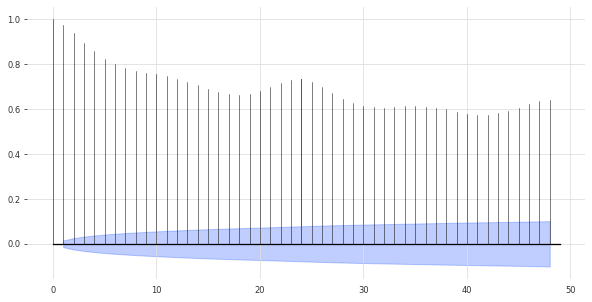

In [5]:
plot_acf(train, m=24, max_lag=48)

In [6]:
check_seasonality(train, m=24, max_lag=48)

# "max lag" refers to the maximum number of time steps or periods that you want to consider when analyzing the relationship between data points in a time series. It represents the farthest point in the past that you believe may have an impact on the current value of the series.

# For example, if you are analyzing daily temperature data and you set the max lag to 7, it means you are considering the temperature values of the past seven days to potentially influence the current day's temperature.

# In our case, we have hourly prices which we belive might be impacted from last days value as well. So, we will be using 48 as our max lag. 


# "m" refers to the seasonality period or the length of a seasonal cycle within the data. It represents the number of time steps or periods required for the series to repeat its pattern. In our case the prices might repeat every 24 hours, so we have m set to 24.

(True, 24)

# NBEATS model

In [7]:
import mlflow

mlflow.set_experiment("price_predictor")

2023/05/14 20:12:37 INFO mlflow.tracking.fluent: Experiment with name 'price_predictor' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///workspace/code/darts/mlruns/523658766393258941', creation_time=1684095157104, experiment_id='523658766393258941', last_update_time=1684095157104, lifecycle_stage='active', name='price_predictor', tags={}>

### Run 1

In [8]:
# Start an MLflow run
mlflow.start_run(run_name="nbeats_pred", nested=True)

<ActiveRun: >

In [9]:
#mlflow.pytorch.autolog() # Auto logs all params

mlflow.log_param('input_chunk_length', 30)
mlflow.log_param('output_chunk_length', 7)
mlflow.log_param('batch_size', 800)
mlflow.log_param('model_name', "nbeats_run")
mlflow.log_param('n_epochs', 10)


# Log parameters
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_run",
)

In [10]:
model_nbeats.fit(train, val_series=test, verbose=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=10` reached.


NBEATSModel(generic_architecture=True, num_stacks=10, num_blocks=1, num_layers=4, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=30, output_chunk_length=7, n_epochs=10, nr_epochs_val_period=1, batch_size=800, model_name=nbeats_run)

In [11]:
pred = model_nbeats.predict(len(test))

#this doesnot work that good, only gives first few prediction as correct then goes wrong if we set n = len(test)
#this happens because it doesnot retrain on the new data rather just simply uses the data till now to make all future predictions

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

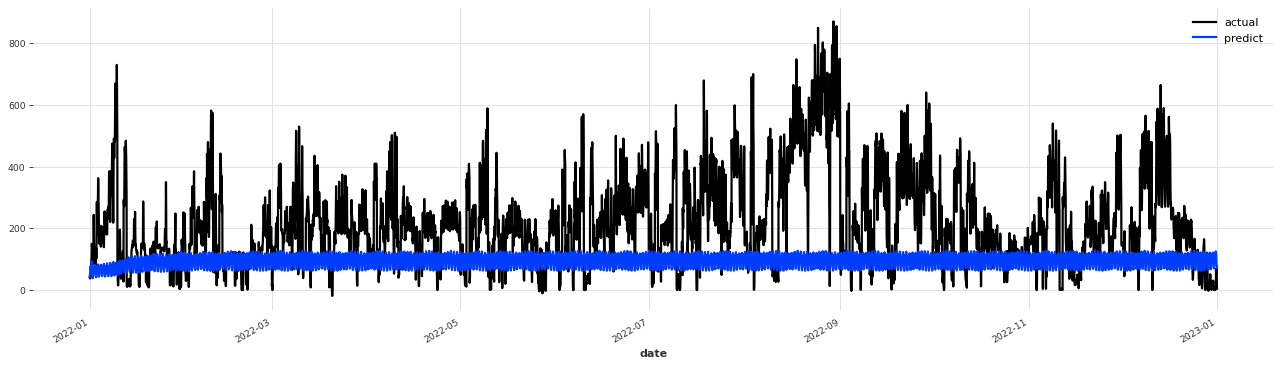

In [12]:
plt.figure(figsize=(20, 5), dpi=80)
test.plot(label="actual")
pred.plot(label="predict")
plt.show()

In [13]:
nbeats0_rmse = rmse(test, pred)
nbeats0_r2   = r2_score(test, pred)

In [15]:
print("RMSE : ", nbeats0_rmse)
print("R2 score : ", nbeats0_r2)

mlflow.log_metric("RMSE", nbeats0_rmse)
mlflow.log_metric("R2 score", nbeats0_r2)

RMSE :  191.17087064605207
R2 score :  -0.7280179791014343


In [16]:
# Register the model in the MLflow registry
run_id_active = mlflow.active_run().info.run_id
model_uri = "runs:/" + run_id_active + "/price_predictor"
model_version = mlflow.register_model(model_uri, "model_nbeats_pred")

Successfully registered model 'model_nbeats_pred'.
2023/05/14 20:16:12 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: model_nbeats_pred, version 1
Created version '1' of model 'model_nbeats_pred'.


In [17]:
mlflow.end_run()

In [18]:
# We will rerun the prediction but with historical forecast method

mlflow.start_run(run_name="nbeats_historical_forecast", nested=True)

<ActiveRun: >

In [19]:
mlflow.log_param('input_chunk_length', 30)
mlflow.log_param('output_chunk_length', 7)
mlflow.log_param('batch_size', 800)
mlflow.log_param('model_name', "nbeats_run")
mlflow.log_param('n_epochs', 100)

10

In [ ]:
pred = model_nbeats.historical_forecasts(series,
                                         forecast_horizon=24, 
                                         stride=24, 
                                         train_length=336, 
                                         start=pd.Timestamp("01.01.2022 01:00"), 
                                         verbose=False)


# This retrains the model after every prediction.
# Retrains the fitted model on past train_length data points, then makes forecast_horizon predictions and moves forward stride length in train set.

# Will train only until start then make predictions

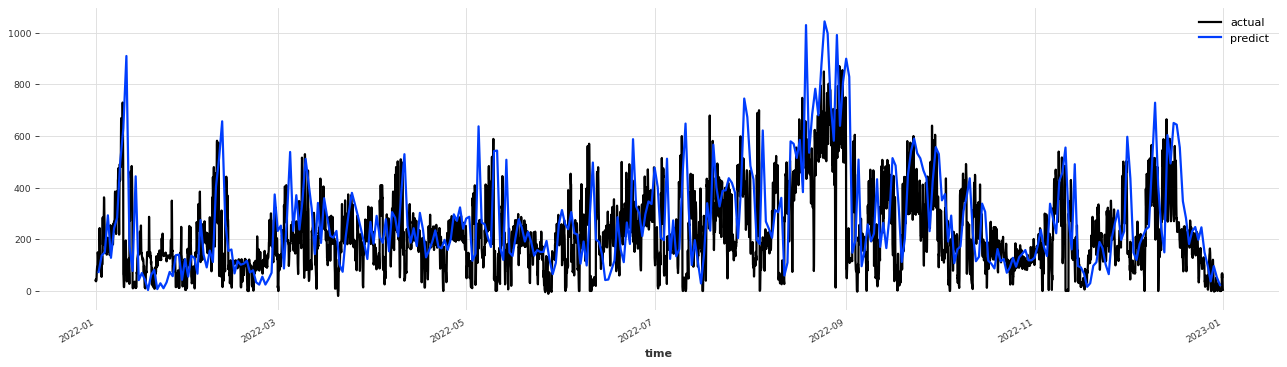

In [24]:
plt.figure(figsize=(20, 5), dpi=80)
test.plot(label="actual")
pred.plot(label="predict")
plt.show()

In [25]:
nbeats1_rmse = rmse(test, pred)
nbeats1_r2   = r2_score(test, pred)

In [28]:
print("RMSE : ", nbeats1_rmse)
print("R2 score : ", nbeats1_r2)

mlflow.log_metric("RMSE", nbeats1_rmse)
mlflow.log_metric("R2 score", nbeats1_r2)

RMSE :  199.92789243914535
R2 score :  -1.2998260319514516


In [29]:
# Register the model in the MLflow registry
run_id_active = mlflow.active_run().info.run_id
model_uri = "runs:/" + run_id_active + "/price_predictor"
model_version = mlflow.register_model(model_uri, "model_nbeats_historical_forecast")

Successfully registered model 'model_nbeats_historical_forecast'.
2023/05/14 20:44:13 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: model_nbeats_historical_forecast, version 1
Created version '1' of model 'model_nbeats_historical_forecast'.


In [30]:
mlflow.end_run()

## Saving and Loading locally

In [ ]:
# Save and load can be dome with nbeats.save() and nbeats.load()

model_nbeats.save("saved_model/nbeats-model")

In [ ]:
# Log parameters
model_nbeats_loaded = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_run",
)

In [ ]:
model_nbeats_loaded.load("saved_model/nbeats-model")